# Plain Logit
## A simple example of estimating a plain logit model

In [1]:
# import packages
import autograd.numpy as np
from autograd import grad
from autograd import hessian
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt


/Users/limingyi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/limingyi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### Compare Gumbel distribution with different parameters

In [2]:
np.random.seed(123)

In [3]:
# For simplicity, we random sample from the gumbel r.v. generator directly

# Gumbel(0,1)
gumbel = np.random.gumbel(size = 10000)

In [6]:
print("Variance = ", np.var(gumbel))

Variance =  1.6620493424413718


A standard Gumbel distribution's variance, $$Var(X) = \pi^2/6$$

In [5]:
print("Analytical variance = ",(np.pi**2)/6)

1.6449340668482264

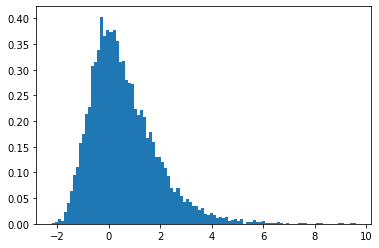

In [7]:
# distribution
plt.hist(gumbel, bins = 100, density=True);

In [8]:
gumbel = np.random.gumbel(loc = 0, scale = 2,size =10000)

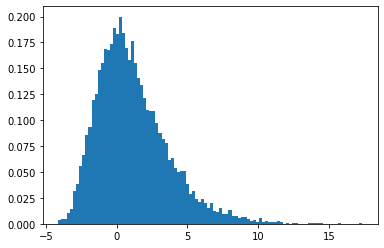

In [9]:
# distribution
plt.hist(gumbel, bins = 100, density=True);

When $X \sim Gumbel(0,\sigma)$, $Var(X)= \frac{\sigma^2 (\pi^2)}{6}$

In [12]:
np.var(gumbel)

6.317964514441353

## Utility function
$$U_{ni} = \alpha + \frac{\beta_1}{income_n}\times price_i + \beta_2 \times quality_{i} + \epsilon_{ni}$$

In [2]:
b = np.array([.4,-2.,1.2])

uid = np.arange(1,5001)

# To ensure income > 0 and avoid the case that income<<1 such that price/income goes to infinity
income = np.random.uniform(low = 1, high = 3, size=5000)
user = pd.DataFrame(data = np.concatenate([uid.reshape(-1,1), income.reshape(-1,1)],axis=1),columns=['uid','income'])

In [3]:

# five potential choices
price = np.random.normal(loc = 0.,scale = 2, size = 5).reshape(-1,1)
quality = np.random.normal( loc = 2.,scale = 3, size=5).reshape(-1,1)
goods = pd.DataFrame(data = np.concatenate([np.arange(1,6).reshape(-1,1), price,quality],axis=1),columns = ['gid','p','q'])

In [4]:
# UserID and GoodsID together uniquely define a row
data = user.merge(goods,how='cross')

In [5]:
P = np.random.uniform(size = 25000)
e = -np.log(-np.log(P))

In [6]:
data['e'] = e

In [7]:
data['con'] = 1

In [8]:
data['p/i'] = data['p']/data['income']

In [9]:
data['v'] = data[['con','p/i','q']].dot(b)

In [10]:
data['u'] = data['v'] + data['e']

In [11]:
data['max_u'] = data.groupby('uid')['u'].transform(max)

/var/folders/vq/y8sw0dx95kg8d24dbz5s_kt80000gn/T/ipykernel_35859/3865488678.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data['max_u'] = data.groupby('uid')['u'].transform(max)


In [12]:
# Observed choice
y = data.query('max_u == u')[['uid','gid']].rename({'gid':'y'},axis=1)
data = data.merge(y)

In [13]:
# Observed choice, one-hot encoding
X = np.array(data[['con','p/i','q']].values)
data['choice'] = 0
data.loc[data.query('y== gid').index,'choice']=1
choice = np.array(data['choice'])

In [14]:
def get_ll(b):
    """
    Params: parameters of the model
    Return: Log-likelihood function of the entire sample
    """
    prob = np.exp(X@b)
    deno = np.array([prob[i:i+5].sum() for i in np.arange(0,X.shape[0],5)])
    deno = np.repeat(deno,repeats = 5)
    l = np.log(prob/deno)
    ll = l@choice
    return -ll

## Maximum Likelihood Estimator
### Good estimates for price and quality

In [15]:
# Use scipy.optimizer.minimize function and choose BFGS method
res = opt.minimize(get_ll,x0=np.random.normal(size=3),method='BFGS')
print('Estimated (beta1,beta2) = ', res.x[1:])
print('True (beta1,beta2) = ',b[1:])

Estimated (beta1,beta2) =  [-2.15633298  1.25727834]
True (beta1,beta2) =  [-2.   1.2]


In [79]:
import autograd.numpy as np
from autograd import grad, hessian

class BFGS:
    """
    Description: This an example of a BFGS optimizer. 
    For faster convergence, I comment out the delta criterion
    """
    def __init__(self, func, x, epsilon=1e-12):
        self.func = func
        self.x = np.array(x, dtype=float)
        self.epsilon = epsilon
#         self.delta = delta
        self.H = np.eye(len(x))
        self.grad_func = grad(func)
        self.hessian_func = hessian(func)
        
    def line_search(self, s, c1=0.6, c2=0.8):
        a = 0.3
        fx = self.func(self.x)
        grads = self.grad_func(self.x)
        
        while True:
            new_x = self.x + a * s
            new_grads = self.grad_func(new_x)
            new_fx = self.func(new_x)
            
            if (new_fx <= fx + c1 * a * (grads.dot(s)) and 
                np.abs(new_grads.dot(s)) < np.abs(c2 * (grads.dot(s)))):
                return a, new_x, new_grads,new_fx
            a *= 2
            if a > 4:
                return 4, new_x, new_grads,new_fx

    def update_hessian(self, z, y):
        H = self.H
        term1 = H - (H.dot(z.reshape(-1, 1)).dot(z.reshape(1, -1)).dot(H)) / (z.dot(H).dot(z))
        term2 = (y.reshape(-1, 1).dot(y.reshape(1, -1))) / (y.dot(z))
        return term1 + term2

    def optimize(self):
        while True:
            fx = self.func(self.x)
            grads = self.grad_func(self.x)
            H = self.hessian_func(self.x)
            s = np.linalg.solve(H, -grads.reshape(-1, 1)).flatten()
            
            lda, x_new, new_grads,new_fx = self.line_search(s)
            z = lda * s
            y = new_grads - grads
            print('Current x: ',self.x)
            self.x = x_new  # Update x to the new position calculated by line_search
            self.H = self.update_hessian(z, y)

            print('Current Log-likelihood: ', fx)
            if (lda < 1e-8) or ((z**2).sum() < self.epsilon * (1 + (self.x**2).sum())):
                print('Iteration ends')
#                 if (grads**2).sum() > self.delta * (1 + np.abs(fx)):
#                     print('Not optimum')
#                 else:
#                     print('Reached an optimum')
                print('Success')
                break



In [80]:
bfgs = BFGS(func= get_ll, x=np.random.normal(size=3))
bfgs.optimize()
# watch convergence 

Current x:  [-1.41435211 -0.29728314  0.33395357]
Current Log-likelihood:  -4931.07789299881
Current x:  [36.39487866 -1.30895192  0.81933995]
Current Log-likelihood:  -3202.787453872354
Current x:  [38.06242993 -1.91732604  1.1132986 ]
Current Log-likelihood:  -2985.3932027986725
Current x:  [24.75222585 -1.96784868  1.21217654]
Current Log-likelihood:  -2976.17646326326
Current x:  [14.44983064 -1.92472101  1.21164827]
Current Log-likelihood:  -2976.0916465956752
Current x:  [ 9.5440672  -1.933371    1.21189231]
Current Log-likelihood:  -2976.088152857904
Current x:  [13.06124635 -1.93164522  1.21184843]
Current Log-likelihood:  -2976.088014645794
Current x:  [ 7.67896403 -1.93199052  1.2118574 ]
Current Log-likelihood:  -2976.088009106078
Current x:  [15.43820316 -1.93192147  1.21185561]
Current Log-likelihood:  -2976.0880088845815
Current x:  [31.90672103 -1.93193528  1.21185597]
Current Log-likelihood:  -2976.088008875721
Current x:  [52.27114554 -1.93193252  1.2118559 ]
Current L

KeyboardInterrupt: 

$$
\hat{\beta} - \beta \sim N(0, -H^{-1})
$$
where $H = \frac{\sum H_n}{n}$

In [38]:
# Due to the positive-definite property, we use cholesky decomposition, that is, H = e'e, where e is the low-triangular error matrix
se = np.linalg.cholesky(res.hess_inv / 5000)
x_lb = np.zeros(3)
x_ub = np.zeros(3)
for i in range(3):
    x_lb[i] = res.x[i] - 1.96 * se[i,i]
    x_ub[i] = res.x[i] + 1.96 * se[i,i]

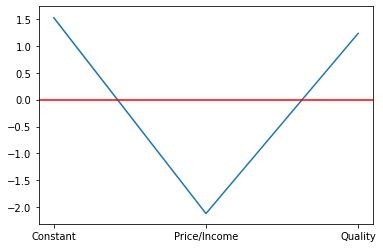

In [39]:
# Coefficients
x = np.arange(3)
fig,ax = plt.subplots(1,1)
ax.plot(x,res.x);
ax.fill_between(x,y1 = x_lb, y2 = x_ub,alpha = .2);
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Constant','Price/Income','Quality']);
ax.axhline(y= 0,color = 'red')


### Willingness to pay

In [1549]:
## WTP for quality for one unit of quality for each consumer
twp = -res.x[2] * income/res.x[1]
# WTP on average
twp.mean()

1.2043567016289796

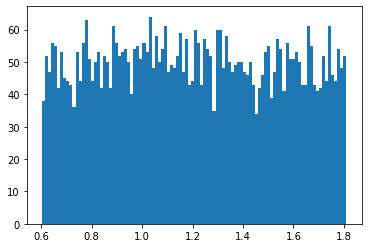

In [1550]:
plt.hist(twp,bins = 100);

## Assume a policy changes the income distribution
### Estimated Utility function. $$U_{ni} = \alpha - \frac{2}{income_n}\times price_i + 1.2 \times quality_{i} + \epsilon_{ni}$$
where $\alpha$ is ignored, since this constant is irrelavant from a policy perspective.

Assume a policy raises consumers' income randomly

In [1558]:
data['new_income'] = data['income'] + np.repeat(np.random.uniform(size= 5000),5)

In [1559]:
data['new_p/i'] = data['p'] / data['new_income']

In [1571]:
# consumer surplus before the policy
data['ev_hat0'] = np.exp(res.x[1] * data['p/i'] + res.x[2] * data['q'])
cs0 = np.log(data.groupby('uid')['ev_hat0'].sum()) * data[['uid','income']].drop_duplicates()['income']/(-res.x[1])

In [1568]:
# consumer surplus after the policy
data['ev_hat1'] = np.exp(res.x[1] * data['new_p/i'] + res.x[2] * data['q'])
cs1 = np.log(data.groupby('uid')['ev_hat1'].sum()) * data[['uid','new_income']].drop_duplicates()['new_income']/(-res.x[1])

In [1572]:
delta_cs = cs1 - cs0

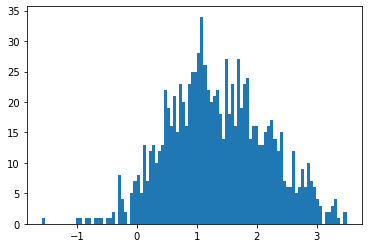

In [1573]:
# Individual welfare change distribution
plt.hist(delta_cs,bins = 100);

In [1593]:
# total welfare percentage change:
print(f'Total welfare rises by {round((cs1.sum() / cs0.sum() - 1)*100,3)} %')

Total welfare rises by 29.286 %
